# Problema 1

In [17]:
import numpy as np
from data_splitting import split_train_validation
from modelo import LogisticRegressionL2
from metrics import save_metrics, confusion_matrix, print_matrix, print_table, plot_combined_roc_curve, plot_combined_pr_curve


In [11]:
def cargar_datos(file_path):
    data = np.loadtxt(file_path, delimiter=',', skiprows=1)  
    X = data[:, :-1]  
    y = data[:, -1]   
    return X, y

def calcular_pesos_clase(y):
    class_0_weight = np.sum(y == 1) / len(y)
    class_1_weight = np.sum(y == 0) / len(y)
    
    class_0_weight *= 1.8
    class_1_weight *= 0.5
    
    return {0: class_0_weight, 1: class_1_weight}
    

def evaluar_modelo(file_path, modelo):    
    X, y = cargar_datos(file_path)
    X_train, X_val, y_train, y_val = split_train_validation(X, y, 0.2, 42)
    modelo.fit(X_train, y_train)
    
    y_pred = modelo.predict(X_val)
    y_prob = modelo.predict_proba(X_val)
    metricas = save_metrics(y_val, y_pred, y_prob)
    
    matriz_conf = confusion_matrix(y_val, y_pred)

    return metricas, y_val, y_prob, matriz_conf

def evaluar_modelo_test(file_path_test, modelo):    
    X_test, y_test = cargar_datos(file_path_test)
    
    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)
    metricas = save_metrics(y_test, y_pred, y_prob)
    matriz_conf = confusion_matrix(y_test, y_pred)
    
    return metricas, y_test, y_prob, matriz_conf

In [12]:
datasets = {
        "Raw Data": "/Users/victoria/Desktop/5tocuatrimestre/ml/tps/tp3ml/machineLearningTP2/problema1/data/preprocessed/train.csv",
        "Undersampling": "/Users/victoria/Desktop/5tocuatrimestre/ml/tps/tp3ml/machineLearningTP2/problema1/data/preprocessed/data_undersampling.csv",
        "Oversampling Duplication": "/Users/victoria/Desktop/5tocuatrimestre/ml/tps/tp3ml/machineLearningTP2/problema1/data/preprocessed/data_oversampling_duplication.csv",
        "Oversampling SMOTE": "/Users/victoria/Desktop/5tocuatrimestre/ml/tps/tp3ml/machineLearningTP2/problema1/data/preprocessed/data_oversampling_smote.csv",
        "Cost Re-weighting": "/Users/victoria/Desktop/5tocuatrimestre/ml/tps/tp3ml/machineLearningTP2/problema1/data/preprocessed/train.csv"
    }


## Evaluación con el dataset de validación

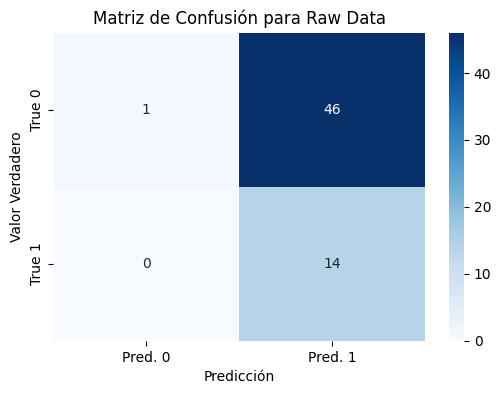

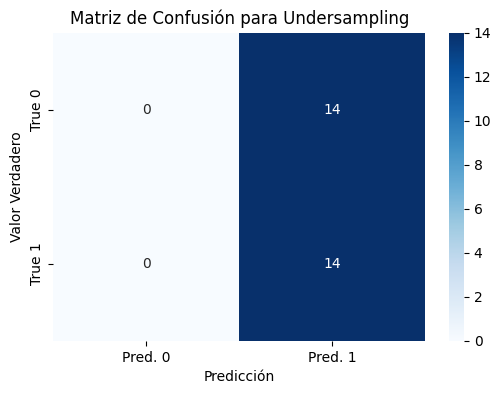

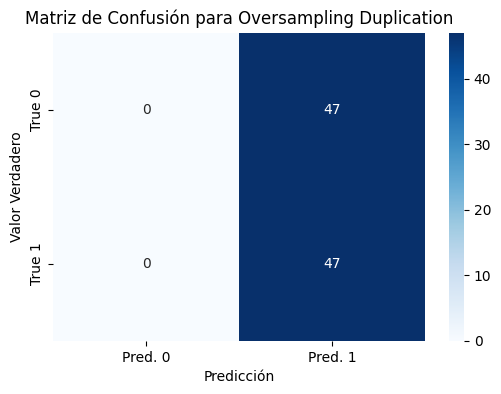

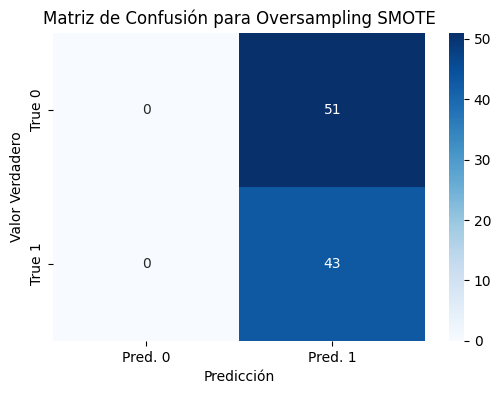

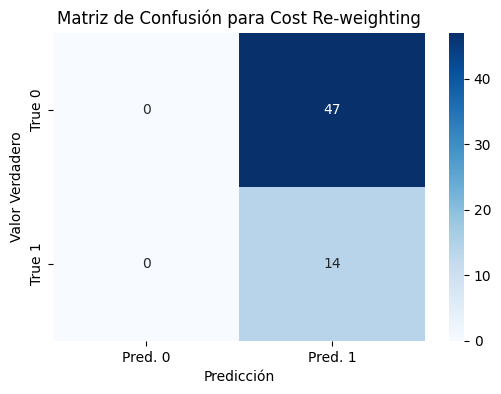

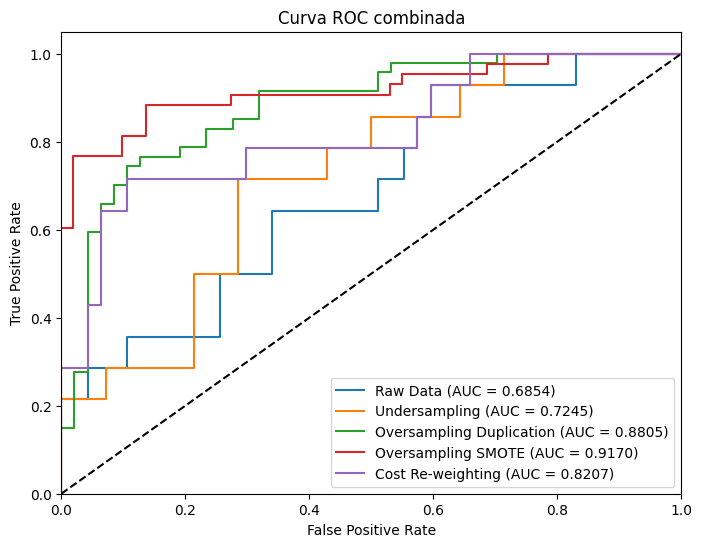

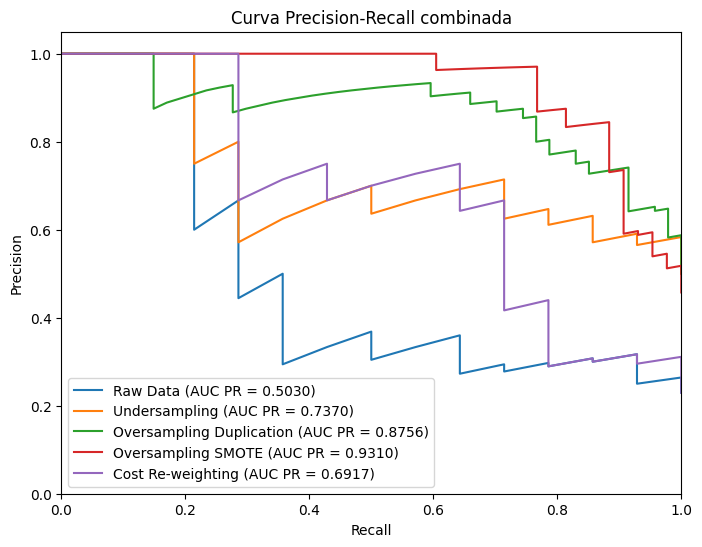

In [19]:
resultados = {}
y_trues = {}
y_probs = {}

modelos_entrenados = {}

for nombre, file_path in datasets.items():
    X, y = cargar_datos(file_path)
    
    if nombre == "Cost Re-weighting":
        class_weights = calcular_pesos_clase(y)
        modelo = LogisticRegressionL2(learning_rate=0.1, lambda_=1, num_iters=20000, class_weights=class_weights, threshold=0.40)
    elif nombre == "Raw Data":
        modelo = LogisticRegressionL2(learning_rate=0.01, lambda_=1, num_iters=20000, threshold=0.4)
    elif nombre == "Undersampling":
        modelo = LogisticRegressionL2(learning_rate=0.00001, lambda_=1, num_iters=10000, threshold=0.4)
    elif nombre == "Oversampling Duplication":
        modelo = LogisticRegressionL2(learning_rate=0.00001, lambda_=1, num_iters=10000, threshold=0.4)
    elif nombre == "Oversampling SMOTE":
        modelo = LogisticRegressionL2(learning_rate=0.00001, lambda_=1, num_iters=10000, threshold=0.4)
    
    metricas, y_val, y_prob, matriz_conf = evaluar_modelo(file_path, modelo)
        
    resultados[nombre] = metricas
    y_trues[nombre] = y_val
    y_probs[nombre] = y_prob

    modelos_entrenados[nombre] = modelo

    print_matrix(matriz_conf, nombre)


Los métodos de re-balanceo implementados mejoraron la detección de la clase minoritaria, pero en consecuencia hubo una completa pérdida en la capacidad de detectar la clase mayoritaria. 




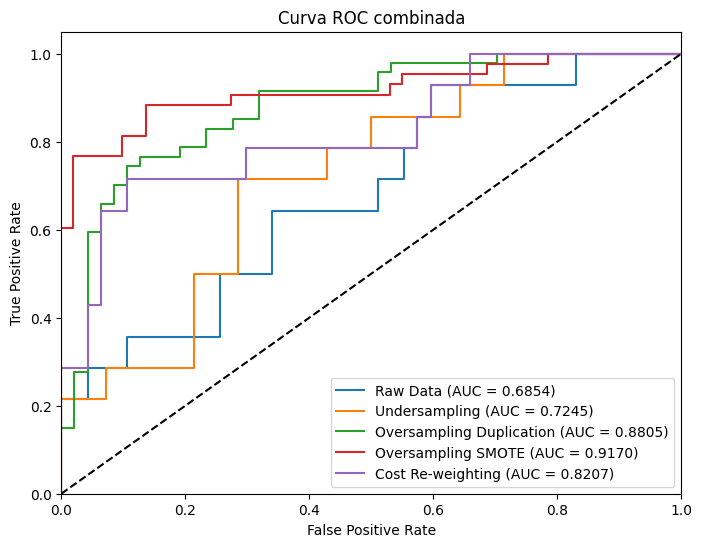

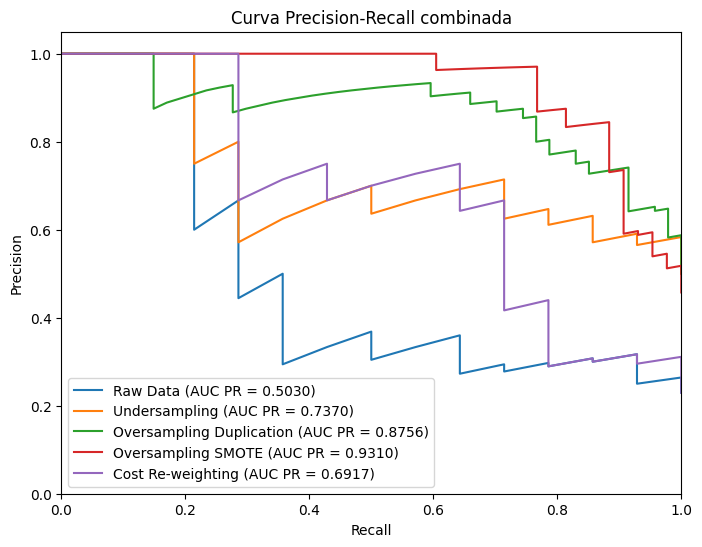

In [20]:
model_results = {}
for nombre in y_trues.keys():
    model_results[nombre] = (y_trues[nombre], y_probs[nombre])
plot_combined_roc_curve(model_results)
plot_combined_pr_curve(model_results)


Las curvas muestran que Oversampling SMOTE es el mejor modelo, con un AUC-ROC de 0.9170 y un AUC-PR de 0.9310, destacando en clasificación y separación de clases. En contraste, el modelo de Raw Data tiene el peor rendimiento, con un AUC-ROC de 0.6854 y un AUC-PR de 0.5030, lo que refleja dificultades para manejar el desbalance de clases.










In [14]:
print("\n=== Resultados Comparativos Dataset Validation ===")
print_table(resultados)



=== Resultados Comparativos Dataset Validation ===
Modelo              Accuracy  Precision Recall    F1-Score  AUC-ROC   AUC-PR    
Raw Data            0.2459    0.2333    1.0000    0.3784    0.6854    0.5030    
Undersampling       0.5000    0.5000    1.0000    0.6667    0.7245    0.7370    
Oversampling Duplication0.5000    0.5000    1.0000    0.6667    0.8805    0.8756    
Oversampling SMOTE  0.4574    0.4574    1.0000    0.6277    0.9170    0.9310    
Cost Re-weighting   0.2295    0.2295    1.0000    0.3733    0.8207    0.6917    


Los resultados muestran que las técnicas de oversampling, particularmente SMOTE y duplicación, proporcionan las mejores métricas en términos de AUC-ROC y AUC-PR, superando al modelo sin re-balanceo y al cost re-weighting. Sin embargo, todos los modelos tienen un recall perfecto, lo que indica que predicen bien la clase positiva, pero comprometen accuracy y precision. Dado que el problema es la detección de cáncer, se debe priorizar el recall (sensibilidad), ya que es crucial minimizar los falsos negativos. Detectar todos los casos de cáncer (clase positiva) es más importante que el número de falsos positivos, pues un falso negativo podría significar que un caso de cáncer no se detecte y no reciba tratamiento.








## Evaluación con el dataset de Test

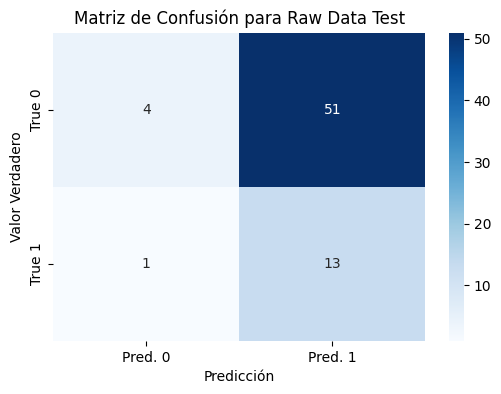

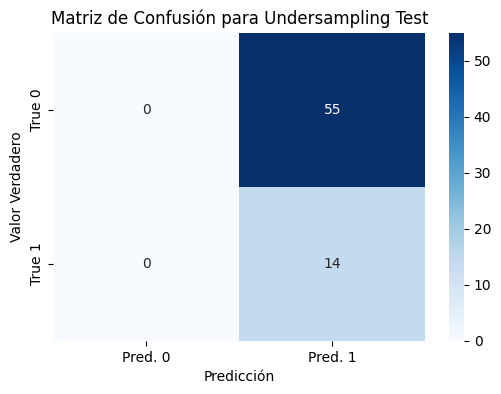

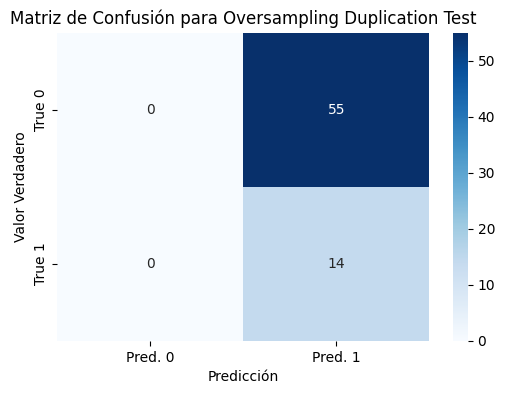

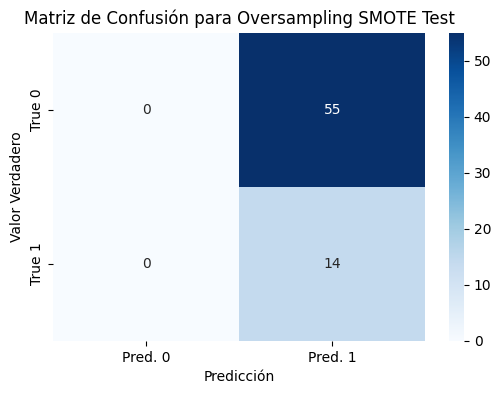

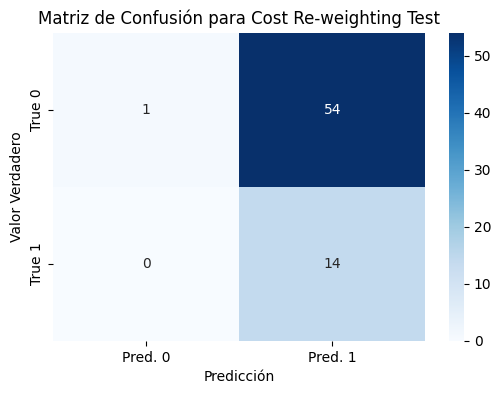

In [15]:
test_file = "/Users/victoria/Desktop/5tocuatrimestre/ml/tps/tp3ml/machineLearningTP2/problema1/data/raw/breast_cancer_test.csv"

resultados_test = {}
y_trues_test = {}
y_probs_test = {}

for nombre, modelo in modelos_entrenados.items():
    metricas_test, y_test, y_prob_test, matriz_conf_test = evaluar_modelo_test(test_file, modelo)
    
    resultados_test[nombre] = metricas_test
    y_trues_test[nombre] = y_test
    y_probs_test[nombre] = y_prob_test
    
    print_matrix(matriz_conf_test, f"{nombre} Test")

En las matrices de confusión del dataset de test, todos los modelos muestran una tendencia significativa a predecir la clase mayoritaria (Pred. 1), lo que lleva a un bajo rendimiento en la detección de la clase minoritaria (True 0). Esto es crítico, ya que en el caso de la detección de cáncer, no detectar la clase de no cáncer (falsos positivos) puede llevar a tratamientos innecesarios y errores diagnósticos. El modelo sin re-balanceo presenta un rendimiento ligeramente mejor al clasificar algunas muestras de la clase True 0, pero en general, se necesita una mayor refinación para mejorar la clasificación de ambas clases.










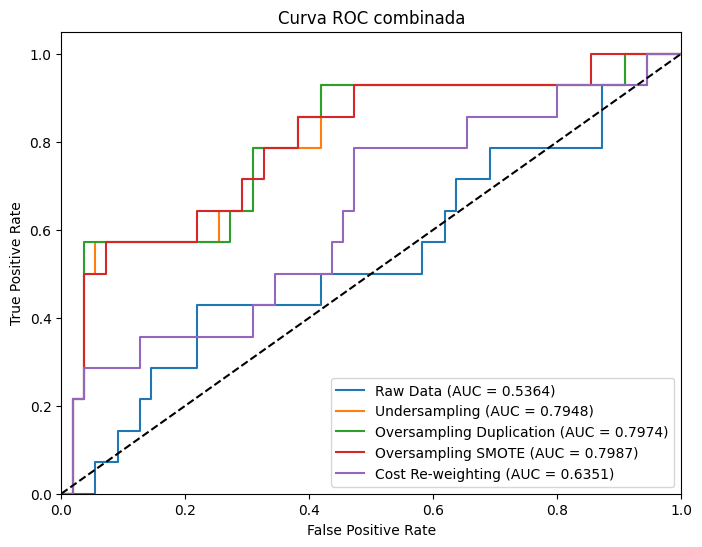

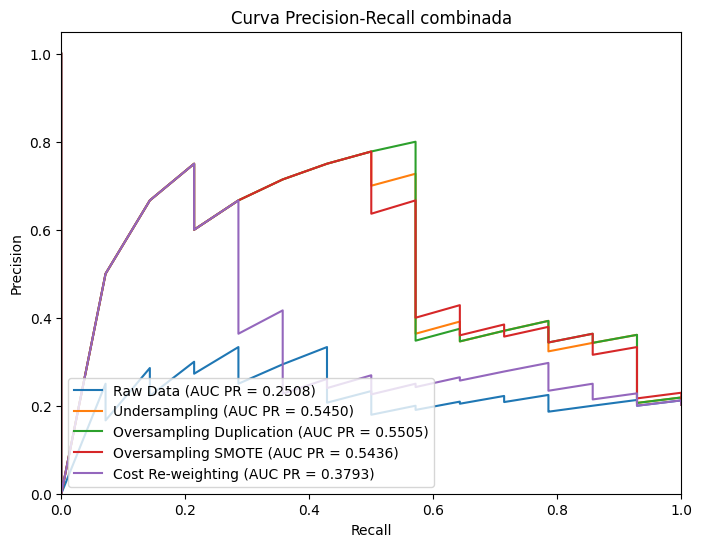

In [22]:
model_results_test = {}
for nombre in y_trues_test.keys():
    model_results_test[nombre] = (y_trues_test[nombre], y_probs_test[nombre])

plot_combined_roc_curve(model_results_test)
plot_combined_pr_curve(model_results_test)

En los resultados del dataset de test, los modelos con oversampling y undersampling presentan un rendimiento similar en términos de AUC-ROC (alrededor de 0.79), destacando en comparación con Raw Data (0.5364) y Cost Re-weighting (0.6351). Sin embargo, en la curva Precision-Recall, Undersampling y Oversampling Duplication sobresalen con AUC-PR superiores a 0.54, lo que indica un mejor equilibrio entre precisión y recall, mientras que Raw Data tiene un desempeño significativamente peor (AUC-PR = 0.2508), reflejando dificultades en la detección precisa.










In [16]:
print("\n=== Resultados Comparativos Dataset Test ===")
print_table(resultados_test)



=== Resultados Comparativos Dataset Test ===
Modelo              Accuracy  Precision Recall    F1-Score  AUC-ROC   AUC-PR    
Raw Data            0.2464    0.2031    0.9286    0.3333    0.5364    0.2508    
Undersampling       0.2029    0.2029    1.0000    0.3373    0.7948    0.5450    
Oversampling Duplication0.2029    0.2029    1.0000    0.3373    0.7974    0.5505    
Oversampling SMOTE  0.2029    0.2029    1.0000    0.3373    0.7987    0.5436    
Cost Re-weighting   0.2174    0.2059    1.0000    0.3415    0.6351    0.3793    


En los resultados del dataset de test, todos los modelos presentan un recall perfecto, lo que significa que son capaces de identificar todos los casos de la clase positiva (cáncer). Sin embargo, la accuracy y precision son muy bajas en todos los casos, lo que indica que estos modelos tienen una alta cantidad de falsos positivos. Modelos como SMOTE y duplicación destacan en términos de AUC-ROC y AUC-PR, lo que sugiere que son buenos para separar las clases en términos de ranking, pero su baja precisión sigue siendo una preocupación crítica. Para priorizar la detección de cáncer, el modelo debe mantener un alto recall, pero es necesario trabajar en reducir los falsos positivos para mejorar la precisión y la utilidad clínica del modelo. 











## Eavaluación final

En este caso, el modelo Oversampling con SMOTE parece ser la mejor opción, ya que mantiene un recall perfecto (lo que es crucial para detectar todos los casos de cáncer) y presenta los mejores resultados en AUC-ROC y AUC-PR, lo que indica una buena capacidad de clasificación general. Aunque la precisión sigue siendo baja, su alta capacidad para separar correctamente las clases justifica su selección como el modelo a llevar a producción. Sin embargo, sería necesario seguir trabajando en la reducción de falsos positivos para aumentar la precisión y mejorar su utilidad en un entorno clínico. Para eso podría considerarse usar otros modelos o hacer una búsqueda exhaustiva de los mejores hiperparámetros.








